# How to Win a Data Science Competition: Final Project Part 1 of 2

## Project Description
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

ID,&ensp;item_cnt_month<br>
0,&emsp;0.5<br>
1,&emsp;0.5<br>
2,&emsp;0.5<br>
3,&emsp;0.5<br>
etc

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

## Methodology
&emsp;&ensp;1) Load data<br>
&emsp;&ensp;2) Initial examination of data, corrective actions, and addition of features<br>
> 2a) Examine ***sales_training*** and correct any issues that are found (outliners, nan, neg values, etc.), add revenue<br>
> 2b) Examine ***test***, add *date_block_num* = 34<br>
> 2c) Examine ***shops***, parse shop names (e.g., city), identify duplicates, add features<br>
> 2d) Update *shop_id* in ***sales_training*** and ***test*** to remove shop duplicates (does not need to be done in the test data); look for data leakage<br>
> 2e) Examine ***item_categories***, create copy, parse category names, add features<br>
> 2f) Examine ***items***<br>

&emsp;&ensp;3) Merge training data and create monthly sales data dataframe<br>
&emsp;&ensp;4) Create initial data set, reduce dtypes<br>
&emsp;&ensp;5) Add previous *item_cnt_monthly* data to the data set<br>
&emsp;&ensp;6) Add mean encodings based on *item_cnt_monthly*<br>
&emsp;&ensp;7) Add mean encodings based on *revenue* and *item_price*<br>
&emsp;&ensp;8) Add other features<br>
&emsp;&ensp;9) Add information related to number of months from first & last purchases<br>
&emsp;&emsp;&emsp;&emsp;&emsp; data is saved as *data_monthly.pkl*<br><br>
&emsp;10) Create Train, Validation, Dev, and Test Sets<br>
&emsp;11) Tune XGBRegressor Hyperparameters with Dev Set<br>
&emsp;&emsp;&emsp;&emsp;&emsp; this step involved experimentaiton with the dev set<br><br>
&emsp;12) Build XGBRegressor Model and Run with Train and Val Sets<br>
&emsp;13) Predict using Test Set and save<br>
&emsp;&emsp;&emsp;&emsp;&emsp; model is saved as *model_xgb*<br>
&emsp;&emsp;&emsp;&emsp;&emsp; at this point the public score is 0.939 and achieves 10/10<br><br>
&emsp;14) Perform Ensembling<br>
&emsp;&emsp;&emsp;&emsp;&emsp; 14a) Use LGB model from week 4. The model is saved as *model_lgb*<br>
&emsp;&emsp;&emsp;&emsp;&emsp; 14b) Ensemble 1: Average XBGRegressor and LGB outputs. Public score was 0.938 and was the best I achieved<br>
&emsp;&emsp;&emsp;&emsp;&emsp; 14c) Ensemble 2: Stack XGBRegressor, LGB, and a linear regressor and then run through another linear regressor. Score was .9465<br>
&emsp;&emsp;&emsp;&emsp;&emsp; 14d) Ensemble 3: Stack XGBRegressor and LGB and then run through another linear regressor. Odly, the score was .9465<br>

&emsp; **Note: **dtype reduction (e.g., int64 -> int8) can save ~75% memory**<br>
&emsp; **Note: **Running time for part 1 is approx 950 seconds**<br>
&emsp; **Note: **Running time for part 2 XGBRegressor is approx 500 seconds**<br>
&emsp; **Note: **Running time for part 2 LGB is approx 150 seconds**<br>

## File description
sales_train.csv&emsp;&emsp;&nbsp; - the training set. Daily historical data from January 2013 to October 2015.  
test.csv&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; - the test set. You need to forecast the sales for these shops and products for November 2015.  
items.csv&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp; - supplemental information about the items/products.  
item_categories.csv  - supplemental information about the items categories.  
shops.csv&emsp;&emsp;&emsp;&emsp;&ensp; - supplemental information about the shops.  

sample_submission.csv - a sample submission file in the correct format.


## Data fields
ID &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - an Id that represents a (Shop, Item) tuple within the test set<br>
shop_id &emsp;&emsp;&emsp;&emsp;&emsp;&ensp; - unique identifier of a shop<br>
item_id &emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp; - unique identifier of a product<br>
item_category_id &ensp;&ensp;&ensp; - unique identifier of item category<br>
item_cnt_day &emsp;&emsp;&emsp; - number of products sold. You are predicting a monthly amount of this measure<br>
item_price &emsp;&emsp;&emsp;&emsp;&nbsp; - current price of an item<br>
date &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - date in format dd/mm/yyyy<br>
date_block_num &ensp;&ensp;&ensp; - a consecutive month number, used for convenience. January 2013 is 0,<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; February 2013 is 1,..., October 2015 is 33<br>
item_name &emsp;&emsp;&emsp;&emsp;&nbsp; - name of item<br>
shop_name &emsp;&emsp;&emsp;&emsp;&nbsp; - name of shop<br>
item_category_name &nbsp;- name of item category<br>

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import pickle
import time
import matplotlib.pyplot as plt
from googletrans import Translator
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

gc.collect()

%matplotlib inline

time_start = time.time()

## 1) Load Data

In [2]:
item_categories = pd.read_csv("item_categories.csv") # item_category_name, item_category_id
items           = pd.read_csv("items.csv")           # item_name, item_id, item_category_id
sales_train     = pd.read_csv("sales_train.csv")     # date, date_block_num, shop_id, item_id, item_price, item_cnt_day
shops           = pd.read_csv("shops.csv")           # shop_name, shop_id
test            = pd.read_csv("test.csv")            # ID, shop_id, item_id

sample_submission = pd.read_csv("sample_submission.csv") # ID, item_cnt_month

## 2) Examine Data (Explatory Data Analysis)

In [3]:
sales_train_c = sales_train.copy()

### 2a) Examine and clean *sales_training*

#### Observations of the training data
> There are 2,935,849 lines of data<br>
> There are 34 months (0 - 33) [not shown]<br>
> There are 57 shops (id 0 - 59) [not shown]<br>
> There are 21,807 items (id 0 - 22,169) [not shown]<br>
> There are no empty cells or nans<br>

> Item prices range from -1 to 307,980. There is one item that is -1 (item_id 2973). The price should be 1249.00.<br>
> There is one item with a really large price (item_id 6066). It will be removed.<br>
> Item counts per day range from -22 to 2,169. There is an outlier at 2,169. Replace with median value (4.0)<br>

In [4]:
sales_train_c.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_train_c.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [6]:
sales_train_c.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
sales_train_c.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

#### Investigate and correct *item_price* ==  -1

In [8]:
sales_train_c[sales_train_c['item_price'] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
print(sales_train_c[(sales_train_c['item_id'] == 2973) & (sales_train_c['date_block_num'] == 4) & (sales_train_c['shop_id'] == 32)])
print(sales_train_c[(sales_train_c['item_id'] == 2973) & (sales_train_c['date_block_num'] == 4) & (sales_train_c['date'] == '15.05.2013')])

# the price should most likely be 1249.00

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484682  23.05.2013               4       32     2973      1249.0           1.0
484683  15.05.2013               4       32     2973        -1.0           1.0
484684  06.05.2013               4       32     2973      2499.0           1.0
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
453034  15.05.2013               4       25     2973      1249.5           1.0
469026  15.05.2013               4       46     2973      1249.5           1.0
469951  15.05.2013               4       45     2973      1249.0           1.0
484683  15.05.2013               4       32     2973        -1.0           1.0


In [10]:
sales_train_c.at[484683,'item_price'] = 1249.00
#training_data.loc[484683]

#### Investigate and correct other outliers for *item_price*

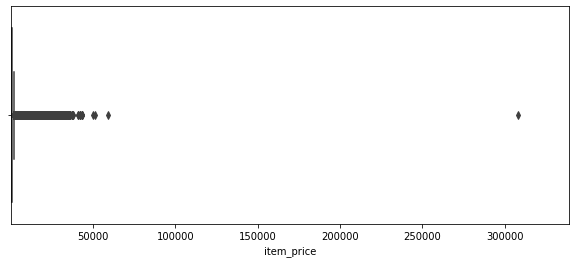

In [11]:
plt.figure(figsize=(10,4))
plt.xlim(sales_train_c.item_price.min(), sales_train_c.item_price.max()*1.1)
sns.boxplot(x=sales_train_c.item_price)

In [12]:
sales_train_c[sales_train_c['item_price'] >= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [13]:
sales_train_c[sales_train_c['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [14]:
items[items['item_id'] == 6066]

# what to do with this item? get rid of it

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [15]:
sales_train_c = sales_train_c[sales_train_c['item_id'] != 6066]

#### Investigate and correct outliers for *item_cnt_day*

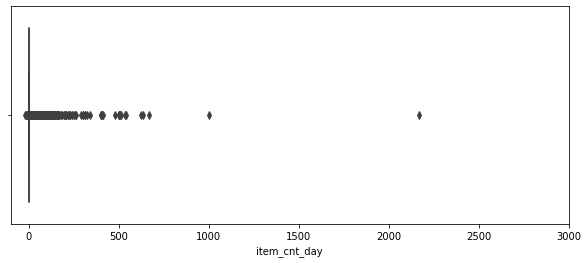

In [16]:
# EDA for checking outlier.
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_train_c.item_cnt_day)

In [17]:
sales_train_c[sales_train_c['item_cnt_day'] > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [18]:
sales_train_c[sales_train_c['item_id'] == 11373].describe()
# replace with the median value of item_cnt_day

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,464.000000,464.0,464.0,464.000000,464.000000
mean,19.948276,12.0,11373.0,367.548909,14.144397
std,8.817658,0.0,0.0,296.953061,104.604937
min,0.000000,12.0,11373.0,0.908714,1.000000
25%,13.000000,12.0,11373.0,184.616848,2.000000
50%,21.000000,12.0,11373.0,281.625000,4.000000
75%,28.000000,12.0,11373.0,443.083333,8.000000
max,33.000000,12.0,11373.0,2137.000000,2169.000000


In [19]:
sales_train_c.at[2909818,'item_cnt_day'] = sales_train_c[sales_train_c['item_id'] == 11373]['item_cnt_day'].median()
#sales_train_c.loc[2909818]

#### Add *revenue* 

In [20]:
sales_train_c['revenue'] = sales_train_c['item_price'] * sales_train_c['item_cnt_day']
sales_train_c.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


### 2b) Examine *shops*
#### Observations of the training data
> The names required normalization. A way to do this was provided in the forums.<br> 
> Two of the shops are online shops. A new column is added to reflect this.<br> 
> There appear to be duplicate names. These need to be addressed in the train and test sets<br> 
> The shop names can be parsed to get the city

#### Normalize and parse shop names; label encode

In [21]:
shops_c = shops.copy()

# normalization from the forums https://www.coursera.org/learn/competitive-data-science/discussions/weeks/5/threads/XAUt7dFREem1EQ494l_jBA

shops_c.replace('РостовНаДону', 'Ростов-на-Дону', inplace=True, regex=True)
shops_c.replace('СПб' , 'Санкт-Петербург', inplace=True, regex=True)
shops_c.replace('Адыгея' , 'Краснодар' , inplace=True, regex=True)
shops_c.replace('Н.Новгород' , 'Нижний Новгород', inplace=True, regex=True)
shops_c.replace('Сергиев Посад ТЦ "7Я"' , 'СергиевПосад ТЦ "7Я"', inplace=True, regex=True)

# fix shop_ids 0 and 1
shops_c.replace('!Якутск', 'Якутск',inplace=True, regex=True)             

In [22]:
# according to the forum, two of the shops are online. mark these in a new column
# online_shops = ['Интернет-магазин ЧC','Цифровой склад 1С-Онлайн']
shops_c['online'] = 0
shops_c.loc[shops['shop_name'] == 'Интернет-магазин ЧС', 'online'] = 1
shops_c.loc[shops['shop_name'] == 'Цифровой склад 1С-Онлайн', 'online'] = 1

In [23]:
# parse the name of the city from shop_name
shops_c['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops_c['city_id'] = LabelEncoder().fit_transform(shops_c['city'])

#### Look for duplicate shop names

In [24]:
# look for duplicate names
shops_c.sort_values(by='city')
# duplicates: [(10,11), (0, 57), (1, 58)]

,shop_name,shop_id,online,city,city_id
0,"Якутск Орджоникидзе, 56 фран",0,0,!Якутск,0
1,"Якутск ТЦ ""Центральный"" фран",1,0,!Якутск,0
2,"Краснодар ТЦ ""Мега""",2,0,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,0,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,0,Волжский,3
5,"Вологда ТРЦ ""Мармелад""",5,0,Вологда,4
6,"Воронеж (Плехановская, 13)",6,0,Воронеж,5
7,"Воронеж ТРЦ ""Максимир""",7,0,Воронеж,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,0,Воронеж,5
9,Выездная Торговля,9,0,Выездная,6


In [25]:
# use this to translate the names
'''
translator = Translator()
translated_list = []
for shop in shops['shop_name']:
    translated = translator.translate(shop)
    translated_list.append(translated.text)
    
shops['shop_name_en'] = translated_list
shops
'''

"\ntranslator = Translator()\ntranslated_list = []\nfor shop in shops['shop_name']:\n    translated = translator.translate(shop)\n    translated_list.append(translated.text)\n    \nshops['shop_name_en'] = translated_list\nshops\n"

### 2c) Examine ***test*** 
> Need to set the index to ID<br>
> There are 214,200 lines of data<br>
> There are 42 shops and 5,100 items<br>
> The data represents a tuple (shop_id, item_id)
> Add *date_block_num* = 34

In [26]:
test.set_index('ID', inplace=True)
test['date_block_num'] = 34
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [27]:
test.describe()

,shop_id,item_id,date_block_num
count,214200.000000,214200.000000,214200.0
mean,31.642857,11019.398627,34.0
std,17.561933,6252.644590,0.0
min,2.000000,30.000000,34.0
25%,16.000000,5381.500000,34.0
50%,34.500000,11203.000000,34.0
75%,47.000000,16071.500000,34.0
max,59.000000,22167.000000,34.0


In [28]:
test.nunique()

shop_id             42
item_id           5100
date_block_num       1
dtype: int64

### 2d) Perform operations on both ***sales_training*** and ***test***
#### Observations in ***item_categories***
> **Data Leakage:** There are 363 item_ids in test that are not in training_data

#### Check for overlap of *shop_id*s between ***training_data*** and ***test***

In [29]:
# check for overlap between shop_ids test and train

test_shops = test['shop_id'].unique()
train_shops = sales_train_c['shop_id'].unique()
test_shops_unique = np.setdiff1d(test_shops, train_shops, assume_unique=False)
train_shops_unique = np.setdiff1d(train_shops, test_shops, assume_unique=False)
#print(test_shops_unique)
#print(train_shops_unique, len(train_shops_unique))

# shop_ids not in test set 0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54
# these need to be added to test with zero values
# duplicated shop_ids in shops (0*,57), (1*,58), (10*,11)
# in train_data, shop_ids should be reassigned as follows {0:57, 1:58, 10:11}

#### Check for overlap of *item_id*s between ***training_data*** and ***test***

In [30]:
# check for differences in shop_id, item_id parings between train and test

test_items = test['item_id'].unique()
train_items = sales_train_c['item_id'].unique()
test_items_unique = np.setdiff1d(test_items, train_items, assume_unique=False)
train_items_unique = np.setdiff1d(train_items, test_items, assume_unique=False)

#print(len(test_items_unique))
#print(len(train_items_unique))

# there are 363 item_ids in test that are not in training_data
# there are 17,070 item_ids that are in training_data and not in test

#### Update duplicate *shop_id*s in ***sales_training*** and ***test***

In [31]:
# in train_data, shop_ids should be reassigned as follows {0:57, 1:58, 10:11}
sales_train_c.loc[sales_train_c['shop_id'] == 0, 'shop_id'] = 57 
sales_train_c.loc[sales_train_c['shop_id'] == 1, 'shop_id'] = 58 
sales_train_c.loc[sales_train_c['shop_id'] == 10, 'shop_id'] = 11 

test.loc[test['shop_id'] == 0, 'shop_id'] = 57 
test.loc[test['shop_id'] == 1, 'shop_id'] = 58 
test.loc[test['shop_id'] == 10, 'shop_id'] = 11 

### 2e) ***item_categories***
#### Observations in ***item_categories***
> There are 84 item categories<br>
> *item_category_name* has the form 'xxx - yyy' <br>
> This can be split into *type* and *subtype* and then label encoded

#### Parse item type and subtypes; label encode them

In [32]:
item_categories_c = item_categories.copy()

# parse the name of the category from item_category_name
item_categories_c['TEMP_SPLIT'] = item_categories_c['item_category_name'].str.split('-')
item_categories_c['type'] = item_categories_c['TEMP_SPLIT'].map(lambda x: x[0].strip())
item_categories_c['subtype'] = item_categories_c['TEMP_SPLIT'].map(lambda x: x[1].strip() 
                                                                   if len(x) > 1 else x[0].strip())

# if the name does not have a subtype, use the type as a subtype
item_categories_c.loc[item_categories_c['subtype'].isnull(), 'subtype'] = item_categories_c['type']

# label encode
item_categories_c['type_id'] = LabelEncoder().fit_transform(item_categories_c['type'])
item_categories_c['subtype_id'] = LabelEncoder().fit_transform(item_categories_c['subtype'])

# drop unnessary columns
item_categories_c.drop(['item_category_name', 'TEMP_SPLIT'], axis=1, inplace=True)
item_categories_c.head()


,item_category_id,type,subtype,type_id,subtype_id
0,0,PC,Гарнитуры/Наушники,0,29
1,1,Аксессуары,PS2,1,9
2,2,Аксессуары,PS3,1,10
3,3,Аксессуары,PS4,1,11
4,4,Аксессуары,PSP,1,13


## 2f) Examine ***items***
#### Observations in the items data
> There are 22,700 item_ids and 84 item_category_ids<br>

In [33]:
items_c = items.copy()
items_c.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [34]:
items_c.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [35]:
items.nunique()

item_name           22170
item_id             22170
item_category_id       84
dtype: int64

## 3) Merge Training Data and Create Monthly Sales DF

> This is done so that the data can be inspected more easlily.

#### Merge data

In [36]:
# merge sales_train, shops, and item_categories into one df. 
merged_sales_train = pd.merge(sales_train_c, items, how='left', on='item_id')
merged_sales_train = pd.merge(merged_sales_train, shops_c, how='left', on='shop_id')
merged_sales_train = pd.merge(merged_sales_train, item_categories_c, how='left', on='item_category_id')

merged_sales_train.drop(['item_name', 'shop_name', 'city', 'type', 'subtype'], axis=1, inplace=True)
merged_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_category_id,online,city_id,type_id,subtype_id
0,02.01.2013,0,59,22154,999.00,1.0,999.00,37,0,31,11,1
1,03.01.2013,0,25,2552,899.00,1.0,899.00,58,0,14,13,27
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00,58,0,14,13,27
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05,58,0,14,13,27
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00,56,0,14,13,3


#### Create Monthly Sales Data DF

In [37]:
group = ['date_block_num','shop_id','online','city_id','item_id','item_category_id','type_id', 'subtype_id']
monthly_sales_train = merged_sales_train.groupby(group) \
                      .agg({'item_cnt_day': ['sum']})
monthly_sales_train.columns = ['item_cnt_month']
monthly_sales_train.reset_index(inplace=True)
monthly_sales_train.head()

,date_block_num,shop_id,online,city_id,item_id,item_category_id,type_id,subtype_id,item_cnt_month
0,0,2,0,1,27,19,5,10,1.0
1,0,2,0,1,33,37,11,1,1.0
2,0,2,0,1,317,45,12,23,1.0
3,0,2,0,1,438,45,12,23,1.0
4,0,2,0,1,471,49,12,39,2.0


## 4) Create Initial Data Set
#### Comments about the initial data set
> There are 10 columns (features) before lagged values are added and 10,913,804 rows<br>
> The rows correspond to all possible date_block_num, shop_id, item_id combinations.<br> 
> *item_cnt_month* needs to be clipped to (0,20) according to project advice 2<br>

In [38]:
# build a data set with all combinations of date_block_num, shop_id, and item_id

# I had to borrow this from https://www.kaggle.com/dlarionov/feature-engineering-xgboost/notebook
# Also, this code is similiar to that from the week 3 project
from itertools import product
init_data_monthly = []
init_data_monthly_cols = ['date_block_num','shop_id','item_id'] 

for i in range(34):
    sales = sales_train_c[sales_train_c['date_block_num'] == i]
    init_data_monthly.append(np.array(list(product([i], sales['shop_id'].unique(), \
                                      sales['item_id'].unique())))) 
init_data_monthly_cols = ['date_block_num','shop_id','item_id']
init_data_monthly = pd.DataFrame(np.vstack(init_data_monthly), columns=init_data_monthly_cols)
init_data_monthly.sort_values(by=init_data_monthly_cols, axis=0, inplace=True)

In [39]:
init_data_monthly = pd.concat([init_data_monthly, test], ignore_index=True, sort=False, keys=init_data_monthly_cols)

In [40]:
data_monthly = pd.merge(init_data_monthly, monthly_sales_train, on=['date_block_num','shop_id','item_id'], how='left')

In [41]:
data_monthly

,date_block_num,shop_id,item_id,online,city_id,item_category_id,type_id,subtype_id,item_cnt_month
0,0,2,19,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,0.0,1.0,19.0,5.0,10.0,1.0
2,0,2,28,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,NaN,NaN,NaN,NaN,NaN,NaN
5,0,2,33,0.0,1.0,37.0,11.0,1.0,1.0
6,0,2,34,NaN,NaN,NaN,NaN,NaN,NaN
7,0,2,35,NaN,NaN,NaN,NaN,NaN,NaN
8,0,2,40,NaN,NaN,NaN,NaN,NaN,NaN
9,0,2,41,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# need to fix all these nans. online, city_id, type_id, and subtype_id need to be filled in
# item_cnt_month and rev_month will be zero
# need to clip item_cnt_month to 20
# reduce dtype or downcast

# fill in nans for online and city_id
data_monthly_shops = data_monthly['shop_id']
shops_temp = pd.merge(data_monthly_shops, shops_c, how='left') #**change from 'inner' to 'left'**
shops_temp.drop(columns=['shop_name', 'city'], inplace=True)

# this works. need to keep online as 0 rather than 0.00, use downcast
data_monthly['online'].fillna(shops_temp['online'], inplace=True)
data_monthly['city_id'].fillna(shops_temp['city_id'], inplace=True)            

# fill in nans for itsm_category_name
data_monthly_items = data_monthly['item_id']
items_temp = pd.merge(data_monthly_items, items_c, how='left')
items_temp.drop(columns=['item_name'], inplace=True)

data_monthly['item_category_id'].fillna(items_temp['item_category_id'], inplace=True)

# fill in nans for type_id and subtype_id
data_monthly_item_cats = data_monthly['item_category_id']
item_cats_temp = pd.merge(data_monthly_item_cats, item_categories_c, how='left')
item_cats_temp.drop(columns=['type', 'subtype'], inplace=True)

data_monthly['type_id'].fillna(item_cats_temp['type_id'], inplace=True)
data_monthly['subtype_id'].fillna(item_cats_temp['subtype_id'], inplace=True)

# need to add zeros to nan in item_cnt_month and rev_month
data_monthly['item_cnt_month'].fillna(0, inplace=True)

# need to clip item_cnt_month to 20
data_monthly['item_cnt_month'] = data_monthly['item_cnt_month'].clip(0,20)

del [[shops_temp, items_temp, item_cats_temp]]
gc.collect();

# looks good!

In [43]:
# need to reduce dtypes
int8 = ['date_block_num', 'shop_id', 'online', 'city_id', 'item_category_id', 'type_id', 'subtype_id']
data_monthly[int8] = data_monthly[int8].astype(np.int8)

int16 = ['item_id']
data_monthly[int16] = data_monthly[int16].astype(np.int16)

float16 = ['item_cnt_month']
data_monthly[float16] = data_monthly[float16].astype(np.float16)

## 5) Add previous months *item_cnt_monthly* data to the Data Set
#### Comments about the data set
> I borrowed code from dlarionov to do this. The code is parameterized so we can add several columns.<br>
> Add *item_cnt_month* for the previous month (potentially previous 2, 3, 6, and 12 months)<br>
> Make sure to fill in nans with 0's

In [44]:
# need to add the previous monthly counts
# borrowed from dlarionov

# this is a parameterized way of adding columns to the data that 
#   contain previous time data (i.e., 'lag_time') 
def add_lag_col(df, lag_times, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    for lag_time in lag_times:
        shifted_temp = temp.copy()
        shifted_temp.columns = ['date_block_num','shop_id','item_id', col+'_prev_'+str(lag_time)]
        shifted_temp['date_block_num'] += lag_time
        df = pd.merge(df, shifted_temp, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
        
    return df

In [45]:
# use several previous months data
previous_months = [1,2,3,6,12]
data_monthly = add_lag_col(data_monthly, previous_months, 'item_cnt_month')

In [46]:
data_monthly.head()

,date_block_num,shop_id,item_id,online,city_id,item_category_id,type_id,subtype_id,item_cnt_month,item_cnt_month_prev_1,item_cnt_month_prev_2,item_cnt_month_prev_3,item_cnt_month_prev_6,item_cnt_month_prev_12
0,0,2,19,0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,0,1,19,5,10,1.0,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0,1,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0,1,23,5,16,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 14 columns):
date_block_num            int8
shop_id                   int8
item_id                   int16
online                    int8
city_id                   int8
item_category_id          int8
type_id                   int8
subtype_id                int8
item_cnt_month            float16
item_cnt_month_prev_1     float16
item_cnt_month_prev_2     float16
item_cnt_month_prev_3     float16
item_cnt_month_prev_6     float16
item_cnt_month_prev_12    float16
dtypes: float16(6), int16(1), int8(7)
memory usage: 307.8 MB


In [48]:
data_monthly

,date_block_num,shop_id,item_id,online,city_id,item_category_id,type_id,subtype_id,item_cnt_month,item_cnt_month_prev_1,item_cnt_month_prev_2,item_cnt_month_prev_3,item_cnt_month_prev_6,item_cnt_month_prev_12
0,0,2,19,0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,0,1,19,5,10,1.0,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0,1,30,8,55,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0,1,23,5,16,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0
5,0,2,33,0,1,37,11,1,1.0,0.0,0.0,0.0,0.0,0.0
6,0,2,34,0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0
7,0,2,35,0,1,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0
8,0,2,40,0,1,57,13,8,0.0,0.0,0.0,0.0,0.0,0.0
9,0,2,41,0,1,57,13,8,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
data_monthly[data_monthly['city_id'] == 0]

,date_block_num,shop_id,item_id,online,city_id,item_category_id,type_id,subtype_id,item_cnt_month,item_cnt_month_prev_1,item_cnt_month_prev_2,item_cnt_month_prev_3,item_cnt_month_prev_6,item_cnt_month_prev_12


## 6) Mean encodings with previous *item_cnt_count*
#### Comments about the data set
> there are many permutations of averages we can add. some include:<br>
>> avg monthly items per shop_id and item_id pair<br>
>> avg monthly items per shop_id<br>
>> avg monthly items per item_id<br>
>> avg monthly items per city_id<br>
>> avg monthly items per retailer type (online or not)<br>
>> avg monthly items per item_category_id<br>
>> avg monthly items per type_id<br>
>> avg monthly items per sub_type_id<br>
>> avg monthly items sold per date_block_id/shop_id/category_id combination<br>
>> avg monthly items sold per date_block_id/shop_id/type_id combination<br>
>> avg monthly items sold per date_block_id/shop_id/subtype_id combination<br>
>> avg monthly items sold per date_block_id/item_id/city_id combination<br>
>> avg monthly items sold per date_block_id/item_id/online combination<br>


>> tot monthly revenue per shop_id<br>
>> normalized ratio between a shop's total monthly revenue and its avg monthly revenue across the period<br>




> at this point there are 11,128,004 rows and 22 columns
> mean encodings are for the previous month (potentially for several previous months)<br>

In [50]:
# add average number of items sold per date_block_id for previous months 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1,2,3,6,12], 'avg_monthly_item-cnt')
data_monthly_temp.drop(['avg_monthly_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [51]:
# add average numbner of items sold per date_block_id/shop_id combination for previous months 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_shop_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'shop_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1,2,3,6,12], 'avg_monthly_shop_item-cnt')
data_monthly_temp.drop(['avg_monthly_shop_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [52]:
# add average numbner of items sold per date_block_id/item_id combination for previous months 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_item_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'item_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1,2,3,6,12], 'avg_monthly_item_item-cnt')
data_monthly_temp.drop(['avg_monthly_item_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [53]:
# add average numbner of items sold per date_block_id/city_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_city_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'city_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_city_item-cnt')
data_monthly_temp.drop(['avg_monthly_city_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [54]:
# add average numbner of items sold per date_block_id/retail_type (online) combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'online']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_online_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'online'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_online_item-cnt')
data_monthly_temp.drop(['avg_monthly_online_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [55]:
# add average numbner of items sold per date_block_id/category_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_category_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'item_category_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_category_item-cnt')
data_monthly_temp.drop(['avg_monthly_category_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [56]:
# add average numbner of items sold per date_block_id/type_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'type_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_type_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'type_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_type_item-cnt')
data_monthly_temp.drop(['avg_monthly_type_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [57]:
# add average numbner of items sold per date_block_id/subtype_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'subtype_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_subtype_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'subtype_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_subtype_item-cnt')
data_monthly_temp.drop(['avg_monthly_subtype_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [58]:
# add average numner of items sold per date_block_id/shop_id/category_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_shop_cat_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_shop_cat_item-cnt')
data_monthly_temp.drop(['avg_monthly_shop_cat_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [59]:
# add average numner of items sold per date_block_id/shop_id/type_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'shop_id', 'type_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_shop_type_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'shop_id', 'type_id'], how='left')

data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_shop_type_item-cnt')
data_monthly_temp.drop(['avg_monthly_shop_type_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [60]:
# add average numner of items sold per date_block_id/shop_id/subtype_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'shop_id', 'subtype_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_shop_subtype_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'shop_id', 'subtype_id'], how='left')
data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_shop_subtype_item-cnt')
data_monthly_temp.drop(['avg_monthly_shop_subtype_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [61]:
# add average numner of items sold per date_block_id/item_id/city_id combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'item_id', 'city_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_item_city_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'item_id', 'city_id'], how='left')
data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_item_city_item-cnt')
data_monthly_temp.drop(['avg_monthly_item_city_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [62]:
# add average numner of items sold per date_block_id/item_id/online combination for the previous month 
data_monthly_temp = data_monthly.copy()

temp = data_monthly_temp.groupby(['date_block_num', 'item_id', 'online']).agg({'item_cnt_month': ['mean']})
temp.columns = ['avg_monthly_item_online_item-cnt']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'item_id', 'online'], how='left')
data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'avg_monthly_item_online_item-cnt')
data_monthly_temp.drop(['avg_monthly_item_online_item-cnt'], axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp]]
gc.collect();

In [63]:
data_monthly.head()

,date_block_num,shop_id,item_id,online,city_id,item_category_id,type_id,subtype_id,item_cnt_month,item_cnt_month_prev_1,...,avg_monthly_city_item-cnt_prev_1,avg_monthly_online_item-cnt_prev_1,avg_monthly_category_item-cnt_prev_1,avg_monthly_type_item-cnt_prev_1,avg_monthly_subtype_item-cnt_prev_1,avg_monthly_shop_cat_item-cnt_prev_1,avg_monthly_shop_type_item-cnt_prev_1,avg_monthly_shop_subtype_item-cnt_prev_1,avg_monthly_item_city_item-cnt_prev_1,avg_monthly_item_online_item-cnt_prev_1
0,0,2,19,0,1,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,0,1,19,5,10,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0,1,30,8,55,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0,1,23,5,16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0,1,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7) Mean encodings with *revenue* and *item_price*

#### Add information about each shop's monthly revenue compared with the average monthly revenue for the period

In [64]:
data_monthly_temp = data_monthly.copy()

# calculate total revenue per shop per month
temp = merged_sales_train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
temp.columns = ['tot_cur_monthly_shop_rev']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'shop_id'], how='left')

# calculate average revenue per shop for the entire period
temp2 = temp.groupby(['shop_id']).agg({'tot_cur_monthly_shop_rev': ['mean']})
temp2.columns = ['avg_monthly_shop_rev']
temp2.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp2, on=['shop_id'], how='left')

# at this point, we have the total shop revenue per month and the average shop revenue across all months
# we can compare current monthly revenue with the period average to obtain useful information
# such as trends

# the difference between the total monthly revenue and the average needs to be normalized (tot-avg)/avg
data_monthly_temp['monthly_shop_revenue_delta'] = (data_monthly_temp['tot_cur_monthly_shop_rev'] / 
                                                   data_monthly_temp['avg_monthly_shop_rev']) - 1
                
# we'll calculate the value for the previous month
data_monthly_temp = add_lag_col(data_monthly_temp, [1], 'monthly_shop_revenue_delta')

data_monthly_temp.drop(['monthly_shop_revenue_delta','tot_cur_monthly_shop_rev','avg_monthly_shop_rev' ], 
                       axis=1, inplace=True)

data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp, temp2]]
gc.collect();

#### Add information about each item's monthly price compared with the average monthly price for the period

In [65]:
data_monthly_temp = data_monthly.copy()

# CHECK THIS FOR NANs. This operation results in some rows where date_blocknum = 34
# to is NAN for monthly_item_price_delta_prev_1. These will need to be fixed. 

# calculate average price per item for the entire period
temp2 = merged_sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
temp2.columns = ['avg_item_price']
temp2.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp2, on=['item_id'], how='left')

# calculate average price per item for each month
temp = merged_sales_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
temp.columns = ['avg_monthly_item_price']
temp.reset_index(inplace=True)

data_monthly_temp = pd.merge(data_monthly_temp, temp, on=['date_block_num', 'item_id'], how='left')

# at this point, we have the average price per item across all months and the average monthly price per item
# we can compare current monthly averate price per item with the period average to obtain useful information
# such as trends

# we'll calculate the value for the previous month
# more lags?
previous_months = [1]
data_monthly_temp = add_lag_col(data_monthly_temp, previous_months, 'avg_monthly_item_price')

# the difference between the monthly average price and the overall average price needs to be normalized 
# (m_avg-o_avg)/o_avg
for previous_month in previous_months:
    data_monthly_temp['monthly_item_price_delta_prev_'+str(previous_month)] = \
    (data_monthly_temp['avg_monthly_item_price_prev_'+str(previous_month)] / data_monthly_temp['avg_item_price'])  - 1    
   
# features to drop
features_to_drop = ['avg_item_price', 'avg_monthly_item_price']
for previous_month in previous_months:
    features_to_drop += ['avg_monthly_item_price' + '_prev_' + str(previous_month)]
    
data_monthly_temp.drop(features_to_drop, axis=1, inplace=True)

# fill in NANs
data_monthly_temp['monthly_item_price_delta_prev_1'].fillna(0, inplace=True)


data_monthly = data_monthly_temp.copy()

del [[data_monthly_temp, temp, temp2]]
gc.collect();

## 8) Add other features
#### Comments about the data set
> need to encode the month and year


#### Add month, year, and the number of days in the month

In [66]:
# add month and year to data set using a formula. encoded as 0, 1, 2, 3, ...
data_monthly['year'] = data_monthly.date_block_num // 12
data_monthly['month'] = data_monthly.date_block_num % 12

days_in_month = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
data_monthly['days_in_month'] = data_monthly['month'].map(days_in_month).astype(np.int8)

## 9) Add information related to number of months from first & last purchases

#### Add the number of months since the last purchase for each item and each item/shop combination

In [67]:
last_month_purchased_at_shop_dict = {}
last_month_purchased_dict         = {}
data_monthly['num_months_since_last_purchase']         = -1 # -1 means no previous purchase
data_monthly['num_months_since_last_purchase_at_shop'] = -1 # -1 means no previous purchase

# this code works because the data is sorted by date_block_num  
for row in data_monthly.itertuples():
    idx = getattr(row, 'Index')
    shop_id = getattr(row, 'shop_id')
    item_id = getattr(row, 'item_id')
    date_block_num = getattr(row, 'date_block_num')
    item_cnt_month = getattr(row,'item_cnt_month')
    
    key = str(item_id) + '_' + str(shop_id)
    
    # this code adds {shopid_itemid:date_block_num} to the dictionary 
    # if item_cnt_monthly is greater than 0. it tracks the latest purchase
    # month for each shopid_itemid pair as the data set is iterated through 
    # we choose >0 so that returns are not intepreted as a sale
    if key not in last_month_purchased_at_shop_dict:
        if item_cnt_month > 0:
            last_month_purchased_at_shop_dict[key] = date_block_num
    
    # if the shopid_itemid pair is already there, calculate the number of 
    # months between the current month (date_block_num) and the last purchase
    # month. Add this to data_monthly. Update last purchase month. 
    else:
        last_month_purchased_at_shop = last_month_purchased_at_shop_dict[key]
        data_monthly.at[idx, 'num_months_since_last_purchase_at_shop'] = \
            date_block_num - last_month_purchased_at_shop
        last_month_purchased_at_shop_dict[key] = date_block_num
        
    if item_id not in last_month_purchased_dict:
        if item_cnt_month > 0:
            last_month_purchased_dict[item_id] = date_block_num 
            
    else:
        last_month_purchased = last_month_purchased_dict[item_id]
        data_monthly.at[idx, 'num_months_since_last_purchase'] = \
            date_block_num - last_month_purchased
        last_month_purchased_dict[item_id] = date_block_num

#### Add the number of months since the first purchase for each item and each item/shop combination

In [68]:
data_monthly['num_months_since_first_purchase_at_shop'] = \
    data_monthly['date_block_num'] - data_monthly.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

data_monthly['num_months_since_first_purchase'] = \
    data_monthly['date_block_num'] - data_monthly.groupby(['item_id'])['date_block_num'].transform('min')

## Save and Cleanup

In [69]:
data_monthly.to_pickle('data_monthly.pkl')
print('Total time (seconds: '+str((time.time() - time_start)))

Total time (seconds: 920.9651958942413


In [70]:
 %who

GridSearchCV	 LabelEncoder	 Translator	 XGBRegressor	 add_lag_col	 data_monthly	 data_monthly_item_cats	 data_monthly_items	 data_monthly_shops	 
date_block_num	 days_in_month	 features_to_drop	 float16	 gc	 group	 i	 idx	 init_data_monthly	 
init_data_monthly_cols	 int16	 int8	 item_categories	 item_categories_c	 item_cnt_month	 item_id	 items	 items_c	 
key	 last_month_purchased	 last_month_purchased_at_shop	 last_month_purchased_at_shop_dict	 last_month_purchased_dict	 mean_squared_error	 merged_sales_train	 monthly_sales_train	 np	 
pd	 pickle	 plot_importance	 plt	 previous_month	 previous_months	 product	 row	 sales	 
sales_train	 sales_train_c	 sample_submission	 shop_id	 shops	 shops_c	 sns	 test	 test_items	 
test_items_unique	 test_shops	 test_shops_unique	 time	 time_start	 train_items	 train_items_unique	 train_shops	 train_shops_unique	 



In [71]:
del [[LabelEncoder,
      Translator,
      add_lag_col,
      data_monthly,
      data_monthly_item_cats,
      data_monthly_items,
      data_monthly_shops,
      date_block_num,
      days_in_month,
      features_to_drop,
      float16,
      group,
      i,
      idx,
      init_data_monthly,
      init_data_monthly_cols,
      int16,
      int8,
      item_categories,
      item_categories_c,
      item_cnt_month,
      item_id,
      items,
      items_c,
      key,
      last_month_purchased,
      last_month_purchased_dict,
      last_month_purchased_at_shop,
      last_month_purchased_at_shop_dict,
      merged_sales_train,
      monthly_sales_train,
      previous_month,
      previous_months,
      product,
      row,
      sales,
      sales_train,
      sales_train_c,
      sample_submission,
      shop_id,
      shops,
      shops_c,
      test,
      test_items,
      test_items_unique,
      test_shops,
      test_shops_unique,
      time_start,
      train_items,
      train_items_unique,
      train_shops,
      train_shops_unique]]

gc.collect();

# STOP